In [ ]:
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Подготовка данных

## Загрузка данных с внешней платформы

В данной работе мы будем использовать данные из одного из соревнований с платформы kaggle. Оно интересно тем, что позволяет не просто использовать dataset MNIST, но и поработать с данными, которые в данном случае представлены в табличном виде.

[Ссылка](https://www.kaggle.com/code/kanncaa1/recurrent-neural-network-with-pytorch) на соревнование.

Для скачивания данных вам потребуется файл с api, который можно создать и скачать из профиля на плафторме kaggle. Для этого надо перейти во вкладку "account" (см. скриншот).

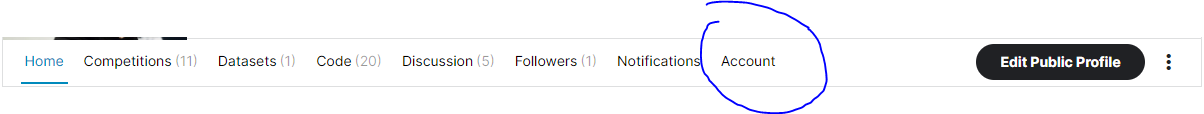

После перехода - создать соответствующий ключ, нажав кнопку, как на скриншоте.

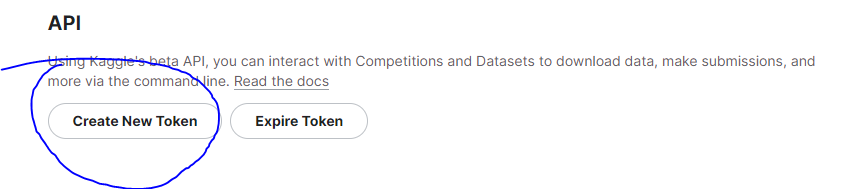

По итогу вы скачаете .json файл, который необходимо загрузить в туже папку, в которой будет лежать исполняемый файл, загружающий данные с kaggle.

После этого достаточно просто скачать данные используя модуль opendtatsets.

In [ ]:
!pip install opendatasets

In [ ]:
od.download("https://www.kaggle.com/competitions/digit-recognizer")

Skipping, found downloaded files in "./digit-recognizer" (use force=True to force download)


## Изучение данных

Прочитаем данные стандатным способом, изучим содеражние.

In [ ]:
df_train = pd.read_csv(r"/content/digit-recognizer/train.csv",dtype = np.float32)

In [ ]:
df_train.shape

(42000, 785)

In [ ]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Структура данных устроена таким образом, что первый столбец хранит значение - цифру, которая описывается пикселями из оставшихся 784 столбцов. Каждый пиксель представляет собой элемент изображения стандартной MNIST-цифры, записанный подряд. Сначала первая строка, затем вторая и так далее.

Разобъём данные на признаки и целевую переменную. И сразу разделим на тренировочную и тестовую (валидационную) выборки, а затем создадим загрузчики данных.

In [ ]:
targets_numpy = df_train.label.values
# в процессе разбиения сразу выполним нормализацию таким образом, чтобы максимально значение было равно 1
features_numpy = df_train.loc[:,df_train.columns != "label"].values/255

features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)

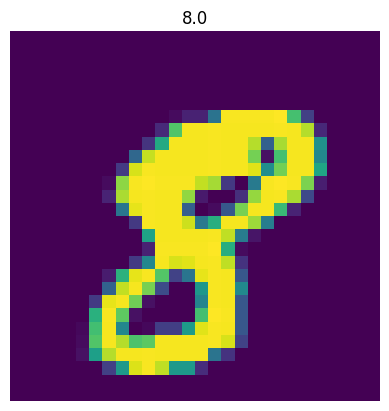

In [ ]:
# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

### Зачем нужны объекты dataset и dataloder?

Стандартная реализация процедуры обучения при использовании pytorch, да и при использовании любого модуля, даже самописного, подразумевает отделение этапа работы с данными от этапа обучения. По существу дело, Dataset и DataLoader - это шаблоны программирования. Первый служит для стандартного хранения данных: признаков и целевой переменной. Второй служит для оптимального доступа к хранимым данным.

In [ ]:
# Создадим тензоры из имеющихся данных для тренировочной и тестовой выборок
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

print(featuresTrain.shape)
print(featuresTest.shape)

torch.Size([33600, 784])
torch.Size([8400, 784])


In [ ]:
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

In [ ]:
train = TensorDataset(featuresTrain, targetsTrain)

train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

In [ ]:
test = TensorDataset(featuresTest, targetsTest)

test = TensorDataset(featuresTest,targetsTest)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# Что такое RNN?

Рекуррентные нейронные сети (Recurrent neural network, RNN) — вид нейронных сетей, где связи между элементами образуют направленную последовательность. Благодаря этому появляется возможность обрабатывать серии событий во времени или последовательные пространственные цепочки. Нейроны, из которых состоят рекурентные нейронные сети, могут быть достаточно сложно устроены, что позволяет хранить внутри нейронов и сети дополнительную информацию. Сети RNN применимы в таких задачах, где нечто целостное разбито на части, например: распознавание рукописного текста или распознавание речи. В последнее время наибольшее распространение получили сеть с долговременной и кратковременной памятью (LSTM) и управляемый рекуррентный блок (GRU).

Вот пример того, как выглядит рекурентная нейронная сеть на картинке.

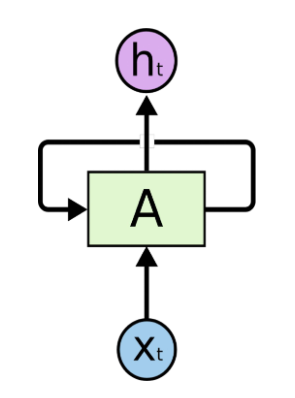

Показанное выше сокращение можно разложить в последовательность вот таким образом:

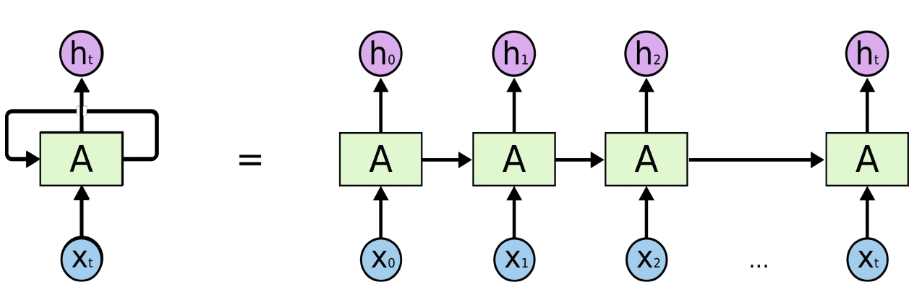

Внутри каждый блок (в простой RNN) устроен достаточно просто:

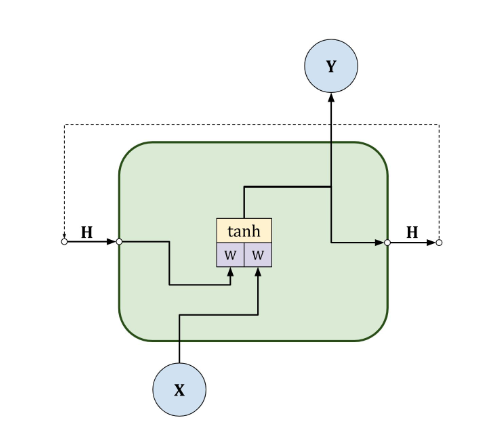

При этом, у всех значений X и у всех значений H есть свои веса, которые настраиваются в процессе обучения. Таким образом, в каждой сети есть число входных значений, число скрытых значений (состояний) и число слоёв (на картинках не было показано) последовательной обработки данных.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')

        # для интерпретации результата так же необходимо использовать линейный слой на выходе в обработке данных
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        # на выходе мы всегда имеет доступ к скрытому состоянию
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

В данном случае мы будем использовать нетипичную работу с сетью и подавать ей на вход по одному ряду пикселей изображения друг за другом, пока не отдадим в нейронную сеть всё изображение целиком.

In [ ]:
input_dim = 28    # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = 10   # output dimension

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

error = nn.CrossEntropyLoss()

learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
seq_dim = 28
for i, (images, labels) in enumerate(train_loader):

    train  = Variable(images.view(-1, seq_dim, input_dim))
    labels = Variable(labels)

    print(train.shape)

    break

torch.Size([100, 28, 28])


In [ ]:
seq_dim = 28
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train  = Variable(images.view(-1, seq_dim, input_dim))
        labels = Variable(labels )

        # Обнуление градиентов
        optimizer.zero_grad()

        # Получение предсказаний
        outputs = model(train)

        # Расчёт функции потерь
        loss = error(outputs, labels)

        # Расчёт градиентов
        loss.backward()

        # Обновление весов
        optimizer.step()

        count += 1

        if count % 250 == 0:
            # Расчёт точности
            correct = 0
            total = 0
            # Прогоняем тестовый набор
            for images, labels in test_loader:
                images = Variable(images.view(-1, seq_dim, input_dim))

                outputs = model(images)

                predicted = torch.max(outputs.data, 1)[1]

                total += labels.size(0)

                correct += (predicted == labels).sum()

            accuracy = 100 * correct / float(total)

            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:

                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data.item(), accuracy))

Iteration: 500  Loss: 2.017138719558716  Accuracy: 23.988094329833984 %
Iteration: 1000  Loss: 1.4137367010116577  Accuracy: 60.71428680419922 %
Iteration: 1500  Loss: 0.5034430027008057  Accuracy: 85.21428680419922 %
Iteration: 2000  Loss: 0.29581305384635925  Accuracy: 88.42857360839844 %
Iteration: 2500  Loss: 0.23403581976890564  Accuracy: 92.11904907226562 %
Iteration: 3000  Loss: 0.11771050095558167  Accuracy: 93.64286041259766 %
Iteration: 3500  Loss: 0.30535659193992615  Accuracy: 92.01190185546875 %
Iteration: 4000  Loss: 0.038408245891332626  Accuracy: 95.23809814453125 %
Iteration: 4500  Loss: 0.17162972688674927  Accuracy: 95.36904907226562 %
Iteration: 5000  Loss: 0.06442722678184509  Accuracy: 95.88095092773438 %
Iteration: 5500  Loss: 0.1182892918586731  Accuracy: 95.5 %
Iteration: 6000  Loss: 0.22387486696243286  Accuracy: 94.92857360839844 %
Iteration: 6500  Loss: 0.07542645186185837  Accuracy: 96.1547622680664 %
Iteration: 7000  Loss: 0.10222028940916061  Accuracy: 96

In [ ]:
model

RNNModel(
  (rnn): RNN(28, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)

Теперь осталось только визуализировать полученный результат наиболее простым образом.

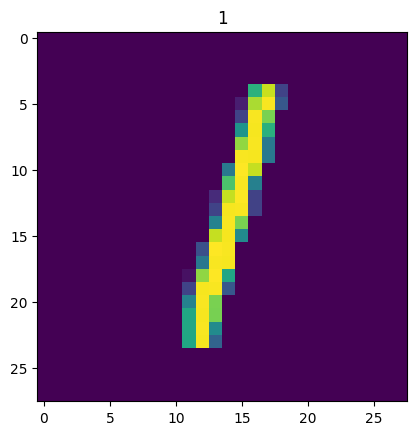

In [ ]:
var = 9

for i, (images, labels) in enumerate(test_loader):
    test  = Variable(images.view(-1, seq_dim, input_dim))
    plt.imshow(test[var].to('cpu').numpy())
    outputs = model(train)
    predicted = torch.max(outputs.data, 1)[1]
    plt.title(str(predicted[var].item()))
    break